In [1]:
import matplotlib.pyplot as plt
from teyssier.sedov import sedovana
from superfv.euler_solver import EulerSolver
from superfv.initial_conditions import sedov
from functools import partial
from superfv.visualization import plot_1d_slice

In [2]:
gamma = 1.4
N = 100
T = 0.8

In [3]:
sim0 = EulerSolver(
    ic=partial(sedov, gamma=gamma, h=1 / N),
    bcx=("reflective", "free"),
    riemann_solver="hllc",
    gamma=gamma,
    nx=N,
    p=0,
)

sim1 = EulerSolver(
    ic=partial(sedov, gamma=gamma, h=1 / N),
    bcx=("reflective", "free"),
    riemann_solver="hllc",
    gamma=gamma,
    nx=N,
    p=1,
    MUSCL=True,
    flux_recipe=2,
)

simzs = EulerSolver(
    ic=partial(sedov, gamma=gamma, h=1 / N, P0=1e-7),
    bcx=("reflective", "free"),
    riemann_solver="hllc",
    gamma=gamma,
    nx=N,
    p=3,
    flux_recipe=2,
    ZS=True,
    PAD={"rho": (0.0, None), "P": (0.0, None)},
    SED=True,
)

simmood = EulerSolver(
    ic=partial(sedov, gamma=gamma, h=1 / N, P0=1e-7),
    bcx=("reflective", "free"),
    riemann_solver="hllc",
    gamma=gamma,
    nx=N,
    p=3,
    flux_recipe=2,
    MOOD=True,
    cascade="muscl1",
    max_MOOD_iters=2,
    NAD=True,
    NAD_rtol=1e-2,
    NAD_atol=1e-7,
    PAD={"rho": (0.0, None), "P": (0.0, None)},
    SED=True,
)

In [4]:
sim0.euler(T)
sim1.musclhancock(T)
simzs.ssprk3(T)
simmood.ssprk3(T)

Step #306 @ t=8.00e-01 | dt=2.90e-03 | min(rho)=2.99e-02, min(P)=0.00e+00 | (done)                  
                                                                                                    

/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero en

Step #301 @ t=8.00e-01 | dt=1.34e-03 | min(rho)=2.83e-02, min(P)=0.00e+00 | (done)                  
                                                                                                    

/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero en

Step #100 @ t=2.25e-01 | dt=2.61e-03 | min(rho)=4.84e-02, min(P)=-3.20e-03                          

/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: invalid value encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: invalid value encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: invalid value encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: invalid value

Step #200 @ t=4.98e-01 | dt=2.83e-03 | min(rho)=3.28e-02, min(P)=-2.21e-03                          

/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: invalid value encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: invalid value encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: invalid value encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: invalid value encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: invalid value

Step #305 @ t=8.00e-01 | dt=3.59e-04 | min(rho)=2.61e-02, min(P)=-2.05e-03 | (done)                 
                                                                                                    

/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: divide by zero encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: overflow encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: divide by zero encou

Step #100 @ t=2.20e-01 | dt=2.49e-03 | min(rho)=5.19e-02, min(P)=-7.31e-04                          

/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: divide by zero encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: overflow encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: divide by zero encou

Step #200 @ t=4.81e-01 | dt=2.70e-03 | min(rho)=3.53e-02, min(P)=-4.74e-04                          

/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: divide by zero encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: overflow encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: divide by zero encou

Step #315 @ t=8.00e-01 | dt=2.66e-03 | min(rho)=2.78e-02, min(P)=-1.19e-03 | (done)                 


/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: divide by zero encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: overflow encountered in divide
  w[idx("passives")] = u[idx("passives")] / rho
/Users/jonathan/Desktop/superfv/superfv/hydro.py:98: RuntimeWarning: divide by zero encountered in divide
  vx = mx / rho if "x" in active_dims else 0.0
/Users/jonathan/Desktop/superfv/superfv/hydro.py:101: RuntimeWarning: invalid value encountered in multiply
  K = 0.5 * rho * (vx**2 + vy**2 + vz**2)
/Users/jonathan/Desktop/superfv/superfv/hydro.py:112: RuntimeWarning: divide by zero encou

In [5]:
dim = 1
E0 = 1
rho0 = 1

r, d, u, P = sedovana(gamma, dim)

r *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (2 / (dim + 2))
d *= rho0
u *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (-dim / (dim + 2))
P *= (E0 / rho0) ** (2.0 / (dim + 2)) * T ** (-2 * dim / (dim + 2)) * rho0

chi0=np.float64(0.97306051566207)


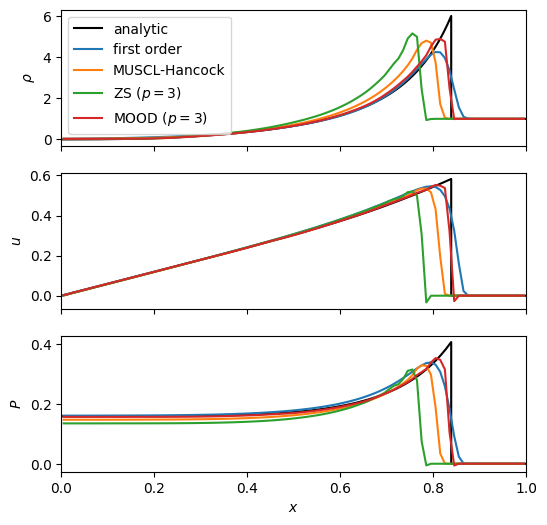

In [6]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 6))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$u$")
axs[2].set_ylabel(r"$P$")

style = dict()

axs[0].plot(r, d, color="k", label="analytic")
plot_1d_slice(sim0, axs[0], "rho", **style, label="first order")
plot_1d_slice(sim1, axs[0], "rho", **style, label="MUSCL-Hancock")
plot_1d_slice(simzs, axs[0], "rho", **style, label=rf"ZS $(p={simzs.p})$")
plot_1d_slice(simmood, axs[0], "rho", **style, label=rf"MOOD $(p={simmood.p})$")

axs[1].plot(r, u, label="analytic", color="k")
plot_1d_slice(sim0, axs[1], "vx", **style)
plot_1d_slice(sim1, axs[1], "vx", **style)
plot_1d_slice(simzs, axs[1], "vx", **style)
plot_1d_slice(simmood, axs[1], "vx", **style)

axs[2].plot(r, P, label="analytic", color="k")
plot_1d_slice(sim0, axs[2], "P", **style, xlabel=True)
plot_1d_slice(sim1, axs[2], "P", **style)
plot_1d_slice(simzs, axs[2], "P", **style)
plot_1d_slice(simmood, axs[2], "P", **style)

axs[0].set_xlim(0, 1)
axs[0].legend()

In [7]:
sim0.print_timings()

Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1            0.20   100.0
take_step                           306            0.19    93.7
compute_dt                          306            0.02     8.8
apply_bc                           1228            0.03    13.0
riemann_solver                      306            0.07    35.9
zhang_shu_limiter                     0               -       -
MOOD_loop                             0               -       -
      detect_troubled_cells           0               -       -
      revise_fluxes                   0               -       -
snapshot                              2            0.00     1.7
minisnapshot                        307            0.01     3.6


In [8]:
sim1.print_timings()

Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1            0.24   100.0
take_step                           301            0.23    93.9
compute_dt                          301            0.02     7.0
apply_bc                           1208            0.03    10.9
riemann_solver                      301            0.07    29.5
zhang_shu_limiter                     0               -       -
MOOD_loop                             0               -       -
      detect_troubled_cells           0               -       -
      revise_fluxes                   0               -       -
snapshot                              2            0.01     2.6
minisnapshot                        302            0.01     2.8


In [9]:
simzs.print_timings()

Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1            0.87   100.0
take_step                           305            0.85    97.9
compute_dt                          305            0.02     1.8
apply_bc                           3712            0.08     9.2
riemann_solver                      927            0.21    24.0
zhang_shu_limiter                   927            0.25    28.6
MOOD_loop                             0               -       -
      detect_troubled_cells           0               -       -
      revise_fluxes                   0               -       -
snapshot                              2            0.01     1.1
minisnapshot                        306            0.01     0.7


In [10]:
simmood.print_timings()

Routine                      # of calls  Total time (s) % time
---------------------------  ----------  --------------  ------
wall                                  1            1.97   100.0
take_step                           315            1.96    99.5
compute_dt                          315            0.02     0.9
apply_bc                           9272            0.21    10.5
riemann_solver                     2744            0.62    31.4
zhang_shu_limiter                     0               -       -
MOOD_loop                           945            1.33    67.7
      detect_troubled_cells        1890            0.52    26.7
      revise_fluxes                1817            0.80    40.5
snapshot                              2            0.00     0.0
minisnapshot                        316            0.01     0.4
